In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
cd drive/My\ Drive/Work\&Study/stanford/coursework/cs236g/project/uda_gan/

[Errno 2] No such file or directory: 'drive/My Drive/Work&Study/stanford/coursework/cs236g/project/uda_gan/'
/content/drive/My Drive/Work&Study/stanford/coursework/cs236g/project/uda_gan


In [29]:
%load_ext autoreload
%autoreload 2
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import time
import datetime, itertools
from torch.autograd import Function, Variable
import torchvision
import torch.utils.data as data
import torchvision.utils as vutils
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from scipy.signal import butter,lfilter,freqz,detrend,stft
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from Dann import *
from GRL import *
from helper_func import *
import gan_da_model as model
from gan_da_trainer import *
from Dataset import *
import random
from cycleGan import *
# np.random.seed(1000)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Form dataset 

In [30]:
# data path
filePath = '../../../../../CMU/research/Damage_diagnosis/transfer/dataset/'
# Knowledge transfer direction
b1b2 = True
# Which vehicle
v_n =10
# Load data
x_dann, label_l, label_s, label_d, label_f, _, _=load_feature(filePath,v_n,b1b2)
x_dann_test, label_l_test, label_s_test, label_d_test, label_f_test, label_bb, damage_ls=load_feature(filePath,v_n,b1b2)

In [32]:
batch_size = 64
# source domain data and labels
x_source, yl_source, ys_source, yd_source, yf_source = shuffle(x_dann[0:round(len(x_dann)/2)], label_l, label_s, label_d, label_f, random_state=0)
# target domain data and labels
x_target, yl_target, ys_target, yd_target, yf_target = shuffle(x_dann[round(len(x_dann)/2):], label_l, label_s, label_d, label_f, random_state=0)
# hold out validation set
hold_out_size = int(len(x_source)*0.2)

dataset_train_source = Dataset(x_source[:-hold_out_size],yl_source[:-hold_out_size],ys_source[:-hold_out_size],\
                             yd_source[:-hold_out_size], yf_source[:-hold_out_size], is_train = True)
dataset_test_source = Dataset(x_source[-hold_out_size:],yl_source[-hold_out_size:],ys_source[-hold_out_size:],\
                             yd_source[-hold_out_size:], yf_source[-hold_out_size:], is_train = False)
dataset_source = Dataset(x_dann[0:round(len(x_dann)/2)],label_l,label_s,\
                             label_d, label_f, is_train = False)
dataset_train_target = Dataset(x_target[:-hold_out_size],yl_target[:-hold_out_size],ys_target[:-hold_out_size],\
                             yd_target[:-hold_out_size], yf_target[:-hold_out_size], is_train = True)
dataset_test_target = Dataset(x_target[-hold_out_size:],yl_target[-hold_out_size:],ys_target[-hold_out_size:],\
                             yd_target[-hold_out_size:], yf_target[-hold_out_size:], is_train = False)
dataset_target = Dataset(x_dann[round(len(x_dann)/2):],label_l,label_s,\
                             label_d, label_f, is_train = False)

source_train = torch.utils.data.DataLoader(dataset_train_source,batch_size, shuffle=True)
source_train_ = torch.utils.data.DataLoader(dataset_train_source,batch_size, shuffle=True)
source = torch.utils.data.DataLoader(dataset_source,round(len(x_dann)/2), shuffle=True)
source_test = torch.utils.data.DataLoader(dataset_test_source,batch_size, shuffle=False)
target_train = torch.utils.data.DataLoader(dataset_train_target,batch_size, shuffle=True)
target_train_ = torch.utils.data.DataLoader(dataset_train_target,batch_size, shuffle=True)
target_test = torch.utils.data.DataLoader(dataset_test_target,batch_size, shuffle=False)
target = torch.utils.data.DataLoader(dataset_target,batch_size, shuffle=True)

# CycleGAN


## Instanciate cycleGan

In [33]:
class Args:
  image_size = 64
  g_conv_dim = 64
  d_conv_dim = 64
  use_reconst_loss = True
  use_labels = False
  num_classes = 13
  train_iters = 10000
  batch_size = batch_size
  num_workers = 1
  lr = 0.0001
  beta1 = 0.5
  beta2 = 0.999
  mode = 'sample'
  model_path = 'results/cyclegan_models'
  sample_path = 'results/samples'
  log_step = 500
  sample_step = 1000

opt = Args()
from cycleGan import *
cycleGan = Solver(opt, source_train, target_train)

## Train models or load trained models

In [34]:
# cycleGan.train() # If you want to train models, comment out this line.
cycleGan.load_models(10000) # if you want to load trained models, comment out this line.

## Get fake source images with target style


In [35]:
x_target_fake = cycleGan.gst(source) # fake target
x_target_fake = np.moveaxis(x_target_fake, 1, -1)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1698: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


## Build the new dataloaders

In [36]:
# source domain data and labels
x_target_fake, yl_source, ys_source, yd_source, yf_source = shuffle(x_target_fake, label_l, label_s, label_d, label_f, random_state=0)
# hold out validation set
hold_out_size = int(len(x_target_fake)*0.2) # TG: 96

dataset_train_target_fake = Dataset(x_target_fake[:-hold_out_size], yl_source[:-hold_out_size], ys_source[:-hold_out_size],\
                             yd_source[:-hold_out_size], yf_source[:-hold_out_size], is_train = True)
dataset_test_target_fake = Dataset(x_target_fake[-hold_out_size:], yl_source[-hold_out_size:], ys_source[-hold_out_size:],\
                             yd_source[-hold_out_size:], yf_source[-hold_out_size:], is_train = False)

target_fake_train = torch.utils.data.DataLoader(dataset_train_target_fake, batch_size, shuffle=True)
# target_fake_train_ = torch.utils.data.DataLoader(dataset_train_target_fake, batch_size, shuffle=True)
target_fake_test = torch.utils.data.DataLoader(dataset_test_target_fake, batch_size, shuffle=False)

# DANN (use the fake target as source)
https://arxiv.org/abs/2006.03641

In [37]:
mode = 'pf'

if mode == 'pf':
  source_train = target_fake_train
  source_test = target_fake_test

In [38]:
device = 'cuda'
model = Dann().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(device)

allepoch = 500 # TG: number of epoch?
CUDA_LAUNCH_BLOCKING = 1
losses = []
accuracies = []
f1s = []

losses_save, accuracy_save = test_epoch(0, 100, source_train, source_test,\
                                               target_train, target_test, model, criterion)
losses = np.append(losses, losses_save)
accuracies = np.append(accuracies, accuracy_save)
# f1s=np.append(f1s,f1_save)
for epoch in range(allepoch):
    len_dataloader = min(len(source_train), len(target_train))
    total_steps = allepoch * len(source_train)
    i = 0
    model.train()
    for batch_idx, (data_source, data_source_, \
                    data_target, data_target_) in enumerate(zip(source_train, \
                    source_train_, target_train, target_train_)):
        start_time = time.time()
        s_img, s_label_l, s_label_s, _, s_label = data_source # fake target. Number of s_label classes is 13.
        # print(s_label_l)
        # print(s_label)
        # TG: the below vars are not used 
        # s_img_, s_label_l_, s_label_s_, _, s_label_ = data_source_

        start_steps = epoch * len(source_train)

        p = float(i + start_steps) / total_steps
        diff = 1.
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        optimizer = optimizer_scheduler(optimizer, p)
        optimizer.zero_grad()

        batch_size = len(s_label)

        # source domain (FAKE target)
        input_s = s_img.to(device)
        pred_d, pred, latent = model(input_s, alpha)

        domain_label_s = torch.zeros(batch_size)
        domain_label_s = domain_label_s.long()

        err_s_label = criterion(pred, s_label.to(device))
        err_s_domain = criterion(pred_d, domain_label_s.to(device))

        # training model using REAL target data
        t_img, t_label_l, t_label_s,_,t_label = data_target
        t_img_, t_label_l_, t_label_s_,_,t_label_ = data_target_

        domain_label_t = torch.ones(batch_size)
        domain_label_t = domain_label_t.long()
        input_t = t_img.to(device)
        pred_d_t, pred_t, latent_t = model(input_t, alpha)
        err_t_domain = criterion(pred_d_t, domain_label_t.to(device))

        err = err_s_label + err_s_domain + err_t_domain
        err.backward()
        optimizer.step()

        i += 1
        losses_save, accuracy_save = test_epoch(epoch, 100, source_train, source_test, \
                                                      target_train, target_test, model, criterion)
        # print('    ', accuracy_save)
    losses = np.vstack((losses, losses_save))
    # print(accuracy_save)
    accuracies=np.vstack((accuracies, accuracy_save))

    if(epoch % 10 == 0):
        print('epoch:{},[{}/{}],s_label:{:.3f},s_domain:{:.3f},t_domain:{:.3f},time{}'.
                format(epoch, i, len_dataloader, float(err_s_label), float(err_s_domain),
                        float(err_t_domain), time.time() - start_time))

# model_dict = model.state_dict()
# exp_name = 'forward'
# torch.save(model_dict, "../../save/model/DA-LS-{}-{}".format(exp_name,rngseed))

# # Save at the end of training
# losses2save = {"Losses": losses, "Accuracy": accuracies, "F1": f1s}
# with open('../../save/losses/loss-{}-{}'.format(exp_name,rngseed), 'wb') as handle:
#     pickle.dump(losses2save, handle, protocol=pickle.HIGHEST_PROTOCOL)


Source Train set: Average loss: 2.5609, Accuracy: 98.0000
Source test set: Average loss: 2.5617
Target train set: Average loss: 2.5609, Accuracy: 98.0000
Target test set: Average loss: 2.5617
s_label torch.Size([64])
domain_label_s torch.Size([64])
Source Train set: Average loss: 2.5614, Accuracy: 98.0000
Source test set: Average loss: 2.5627
Target train set: Average loss: 2.5614, Accuracy: 98.0000
Target test set: Average loss: 2.5628
s_label torch.Size([64])
domain_label_s torch.Size([64])
Source Train set: Average loss: 2.5613, Accuracy: 98.0000
Source test set: Average loss: 2.5627
Target train set: Average loss: 2.5613, Accuracy: 98.0000
Target test set: Average loss: 2.5627
s_label torch.Size([64])
domain_label_s torch.Size([64])
Source Train set: Average loss: 2.5612, Accuracy: 98.0000
Source test set: Average loss: 2.5626
Target train set: Average loss: 2.5612, Accuracy: 98.0000
Target test set: Average loss: 2.5626
s_label torch.Size([64])
domain_label_s torch.Size([64])
Sour

KeyboardInterrupt: ignored

## Plot loss and accuracy

Text(0, 0.5, 'Loss')

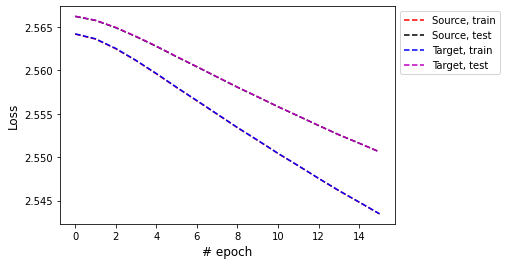

In [ ]:
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(6,4))
losses = np.array(losses)
color = ['r','k','b','m']
for i in range(4):
    plt.plot(losses[:,i],c=color[i],ls='--')
lgd=plt.legend(['Source, train',\
           'Source, test',\
           'Target, train',\
           'Target, test'],loc=2,bbox_to_anchor=(1, 1),fontsize=10)
plt.xlabel('# epoch',fontsize=12)
plt.ylabel('Loss',fontsize=12)

Text(0.5, 1.0, 'Accuracy')

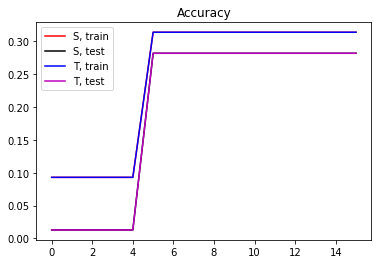

In [ ]:
accuracies = np.array(accuracies)
color = ['r','k','b','m']
norm = [390*0.8,390*0.2,390*0.8,390*0.2]
for i in range(4):
    plt.plot(accuracies[:,i]/norm[i],c=color[i],ls='-')
plt.legend(['S, train',\
           'S, test',\
           'T, train',\
           'T, test'])
plt.title('Accuracy')

# Generate to adapt (Baseline):
https://openaccess.thecvf.com/content_cvpr_2018/papers/Sankaranarayanan_Generate_to_Adapt_CVPR_2018_paper.pdf

## Train

In [ ]:
class Args:
  batchSize=batch_size
  nz = 128 #size of the latent z vector
  ngf = 64 #Number of filters to use in the generator network
  ndf = 64 #Number of filters to use in the discriminator network
  nepochs = 500 #number of epochs to train for
  lr = 0.0005 #learning rate, default=0.0002
  beta1 = 0.8 #beta1 for adam. default=0.5
  gpu = 1 #GPU to use, -1 for CPU training
  outf = 'results' #folder to output images and model checkpoints
  manualSeed = 1
  adv_weight = 0.1 #weight for adv loss
  lrd = 0.0001 #learning rate decay, default=0.0002
  alpha = 0.3 #multiplicative factor for target adv. loss

opt = Args()
# print(opt)

# Setting random seed
if opt.manualSeed is None:
    opt.manualSeed = random.randint(1, 10000)
print("Random Seed: ", opt.manualSeed)
random.seed(opt.manualSeed)
torch.manual_seed(opt.manualSeed)
if opt.gpu>=0:
    torch.cuda.manual_seed_all(opt.manualSeed)

# GPU/CPU flags
torch.backends.cudnn.benchmark = True
if torch.cuda.is_available() and opt.gpu == -1:
    print("WARNING: You have a CUDA device, so you should probably run with --gpu [gpu id]")
if opt.gpu>=0:
    os.environ['CUDA_VISIBLE_DEVICES'] = str(opt.gpu)

nclasses = 13

GTA_trainer = GTA(opt, nclasses, source_train, source_test, target_train)
GTA_trainer.train()

Random Seed:  1


/content/drive/My Drive/Work&Study/stanford/coursework/cs236g/project/uda_gan/gan_da_trainer.py:72: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputv, labelv = Variable(inputs.cuda(), volatile=True), Variable(labels.cuda())


2021-03-08 04:59:26.910317| Epoch: 50, Val Accuracy: 72.916667 %
Test Accuracy: 20.833333 %


/content/drive/My Drive/Work&Study/stanford/coursework/cs236g/project/uda_gan/gan_da_trainer.py:97: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputv, labelv = Variable(inputs, volatile=True), Variable(labels)


2021-03-08 05:00:00.202221| Epoch: 100, Val Accuracy: 79.166667 %
Test Accuracy: 22.708333 %
2021-03-08 05:00:33.047461| Epoch: 150, Val Accuracy: 86.458333 %
Test Accuracy: 21.666667 %
2021-03-08 05:01:05.879743| Epoch: 200, Val Accuracy: 84.375000 %
Test Accuracy: 24.166667 %
2021-03-08 05:01:38.857096| Epoch: 250, Val Accuracy: 86.458333 %
Test Accuracy: 22.500000 %
2021-03-08 05:02:11.540171| Epoch: 300, Val Accuracy: 85.416667 %
Test Accuracy: 20.208333 %
2021-03-08 05:02:44.389678| Epoch: 350, Val Accuracy: 86.458333 %
Test Accuracy: 21.041667 %
2021-03-08 05:03:17.038020| Epoch: 400, Val Accuracy: 84.375000 %
Test Accuracy: 21.875000 %
2021-03-08 05:03:49.891615| Epoch: 450, Val Accuracy: 84.375000 %
Test Accuracy: 20.416667 %
2021-03-08 05:04:22.467954| Epoch: 500, Val Accuracy: 85.416667 %
Test Accuracy: 26.458333 %


## Test

In [ ]:
class Args:
  batchSize=100
  nz = 128 #size of the latent z vector
  ngf = 64 #Number of filters to use in the generator network
  ndf = 64 #Number of filters to use in the discriminator network
  gpu = 1 #GPU to use, -1 for CPU training
  checkpoint_dir = 'results/models'
  model_best = 0

opt = Args()

netF = model._netF(opt)
netC = model._netC(opt, nclasses)

if opt.model_best == 0: 
    netF_path = os.path.join(opt.checkpoint_dir, 'netF.pth')
    netC_path = os.path.join(opt.checkpoint_dir, 'netC.pth')
else:
    netF_path = os.path.join(opt.checkpoint_dir, 'model_best_netF.pth')
    netC_path = os.path.join(opt.checkpoint_dir, 'model_best_netC.pth')
    
netF.load_state_dict(torch.load(netF_path))
netC.load_state_dict(torch.load(netC_path))

if opt.gpu>=0:
    netF.cuda()
    netC.cuda()
    
# Testing

netF.eval()
netC.eval()
    
total = 0
correct = 0

for i, datas in enumerate(target_train):
    inputs,_,_,_,labels = datas
    if opt.gpu>=0:
        inputs, labels = inputs.cuda(), labels.cuda()
    inputv, labelv = Variable(inputs, volatile=True), Variable(labels)

    outC = netC(netF(inputv))
    _, predicted = torch.max(outC.data, 1)        
    total += labels.size(0)
    correct += ((predicted == labels.cuda()).sum())
    
test_acc = 100*float(correct)/total
print('Test Accuracy: %f %%' % (test_acc))

SyntaxError: ignored